# Model Comparison Analysis Code #

This notebook extracts and computes the performance scores from Experiments E1 and E2 in the paper. There may be slight differences due to random seeds and numerical effects, but the results should be very similar to plots and tables in the paper. 

In [1]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import sem

In [2]:
# load data from the pickles
resultsdir = "../code/results"

# Analysis Comparing GP and RNN models #

In [10]:
def getDFBScores(scores):
    DFBscores = []
    for score in scores:
        reldiffs = np.zeros(score.shape)
        minvals = np.min(score, axis=1)
        for a in range(len(algs)):
            reldiffs[:,a] = (score[:,a] - minvals) 
        DFBscores += [reldiffs]
    return DFBscores

In [11]:
def getStats(data):
    return (np.mean(nll,0), np.std(nll,0), sem(nll,0), np.median(nll,0))

In [12]:
exps = ["3participant","LOOtask"]
doms = ["household", "driving"]
algs = ["RNN", "POGP", "PMGP", "GP", "LG", "CT"] 
nalgs = len(algs)
taskrepsize = 2

scorenames = ["NLL", "MAE"]
domnames = ["Household", "Driving"]

def getResults(dom, splittype, algs, sepparts=False):
    nparts = 32

    if splittype == "LOOtask":
        N = 12
    elif splittype == "random":
        N = 10
    elif splittype == "3participant":
        nfolds = 10
        N = nfolds
        
    if sepparts:
        nll = []
        mae = []
        for aid in range(len(algs)):
            nll += [[]]
            mae += [[]]
            
    else:
        nll = np.zeros((N, nalgs))
        mae = np.zeros((N, nalgs))
    
    # default parametres
    gpmode = 0
    taskrepsize = 2 # default

    for aid, alg in zip(range(nalgs), algs):
        
        # algorithm specific parameters
        if alg == "RNN":
            modeltype = "neural"
            gpmode = 1
            taskrepsize = 30
        elif alg == "GP":
            modeltype = "gp"
            gpmode = 0
            taskrepsize = 3
        elif alg == "PMGP":
            modeltype = "gp"
            gpmode = 1
            taskrepsize = 3
        elif alg == "POGP":
            modeltype = "gp"
            gpmode = 2
            taskrepsize = 3
        elif alg == "LG":
            modeltype = "lineargaussian"
            gpmode = 0
            taskrepsize = 2 #unused
        elif alg == "CT":
            modeltype = "constant"
            gpmode = 0
            taskrepsize = 2 #unused
        else:
            raise ValueError("No Such Alg!")


        filename =  dom + "_" + modeltype + "_" + str(taskrepsize) + "_" + splittype + "_" + str(gpmode) + ".pkl"
        with open(os.path.join(resultsdir, filename), 'rb') as input:
            data = pickle.load(input)
        i = 0
        if sepparts:
            for d in data:
                snll = []
                amae = []
                for elem in d[2]:
                    imae = np.abs(elem[0]-elem[1])
                    inll = -(elem[1]*np.log(elem[0]) - (1.0-elem[1])*(1.0-np.log(elem[0])))
                    snll += [inll]
                    amae += [imae]
                nll[aid] += [np.sum(inll)]
                mae[aid] += [np.mean(imae)]
#                     nll[aid] += [inll]
#                     mae[aid] += [imae]
        
                
        else:
            for d in data:
                nll[i, aid] = d[1]
                mae[i, aid] = d[0]
                i += 1
    
    nll = np.array(nll)
    mae = np.array(mae)
    
    if sepparts:
        nll = np.transpose(nll)
        mae = np.transpose(mae)
    
    return (nll, mae)

In [13]:
allresults = []

ndoms=len(doms)
sepparts = False
scaleMAE = False #only true if you want to compare against the older metrics

for splittype in exps:
    for i, dom in zip(range(ndoms), doms):
        nll, mae = getResults(dom, splittype, algs, sepparts=sepparts)
        print(splittype, dom, np.sum(nll == 0, axis=0))
        #print(nll)

3participant household [0 0 0 0 0 0]
3participant driving [0 0 0 0 0 0]
LOOtask household [0 0 0 0 0 0]
LOOtask driving [0 0 0 0 0 0]


## Plots for Paper ##

The boxplots in the paper. We show the boxplots and leave the mean and se's for the table.

In [14]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [15]:
sizeOfFont = 12
tickFontProperties = {'family':'sans-serif','sans-serif':['Helvetica'],
    'weight' : 'normal', 'size' : sizeOfFont}

/home/haroldsoh/anaconda3/envs/torch0.3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


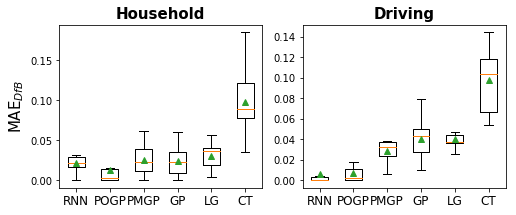

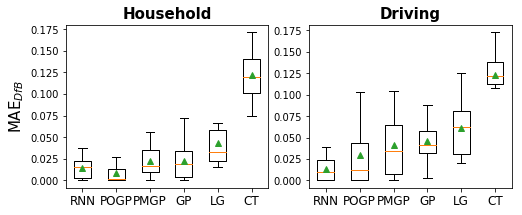

In [16]:
allresults = []
scorenames = ["NLL", "MAE"]
domnames = ["Household", "Driving"]
for splittype in exps:
    f, axarr = plt.subplots(1, 2,figsize=(8, 3))
    #f.suptitle(splittype, fontsize=16)
    
    for i, dom in zip(range(2), doms):
        nll, mae = getResults(dom, splittype, algs)
        nll, mae = getDFBScores([nll, mae])
        if scaleMAE:
            mae *= 7
        for j, score in zip(range(1), [mae]):
            p1 = axarr[i].boxplot(score, showmeans=True, showfliers=False)
            #axarr[i].set_ylim(0.4, 1.0)
            #axarr[i].yaxis.set_ticks(np.arange( 0.4, np.max(nll[:])+0.1, 0.2))
            #minorLocator = MultipleLocator(0.05)

            #axarr[i].yaxis.set_minor_locator(minorLocator)
            axarr[i].set_title(domnames[i], fontsize=15, fontweight="bold", fontname="Helvetica")
            if i == 0:
                axarr[i].set_ylabel("$\mathrm{MAE}_{DfB}$", fontsize=15, fontname="Helvetica" )
            plt.setp(axarr[i].get_xticklabels(), fontsize=12, fontname="Helvetica" )
    plt.setp(axarr, xticks=range(1,len(algs)+1), xticklabels=algs);
    plt.savefig(splittype + ".pdf", format="pdf")
    
    #plt.ylim(0.4, 1.3)
    

Next, let's output the tables in a LaTeX table format. 

In [17]:
allresults = []
scorenames = ["NLL", "MAE"]
domnames = ["Household", "Driving"]

for splittype in exps:
    print()
    print(splittype)
    print()
    means = np.zeros((nalgs, 8))
    sems = np.zeros((nalgs, 8))
    
    for i, dom in zip(range(2), doms):
        nll, mae = getResults(dom, splittype, algs)
        #dnll, dmae = getDFBScores([nll, mae])
        
        means[:, i*2] = np.mean(nll, axis=0)
        #means[:, i*4+1] = np.mean(dnll, axis=0)
        means[:, i*2+1] = np.mean(mae, axis=0)
        #means[:, i*4+3] = np.mean(dmae, axis=0)
        
        sems[:, i*2] = sem(nll, axis=0)
        #sems[:, i*4+1] = sem(dnll, axis=0)
        sems[:, i*2+1] = sem(mae, axis=0)
        #sems[:, i*4+3] = sem(dmae, axis=0)
    
    for i in range(nalgs):

        
        # get the minimum indices
        print("\\multirow{2}{*} {%s} "%(algs[i]), end="")
        
        for j in range(len(doms)):
            for k in range(2):
                minidx = np.argmin(means[:, j*2+k])
                if i == minidx:
                    print("& \\textbf{%.3f}"%(means[i,j*2+k]), end="")
                else:
                    print("& %.3f "%(means[i,j*2+k]), end="")
                
        print("\\\\")
        
        for j in range(len(doms)):
            for k in range(2):
                minidx = np.argmin(means[:, j*2+k])
                if i == minidx:
                    print("& (\\textbf{%.3f})"%(sems[i,j*2+k]), end="")
                else:
                    print("& (%.3f) "%(sems[i,j*2+k]), end="")
        
        
        print("\\\\")
        print("\\hline")
    
    #print(means)
    #print(sems)
    
    
    #plt.ylim(0.4, 1.3)
    


3participant

\multirow{2}{*} {RNN} & 0.571 & 0.173 & \textbf{0.549}& \textbf{0.175}\\
& (0.023) & (0.010) & (\textbf{0.024})& (\textbf{0.011})\\
\hline
\multirow{2}{*} {POGP} & \textbf{0.561}& \textbf{0.164}& 0.559 & 0.175 \\
& (\textbf{0.027})& (\textbf{0.013})& (0.028) & (0.012) \\
\hline
\multirow{2}{*} {PMGP} & 0.577 & 0.176 & 0.567 & 0.197 \\
& (0.019) & (0.010) & (0.018) & (0.011) \\
\hline
\multirow{2}{*} {GP} & 0.575 & 0.175 & 0.588 & 0.208 \\
& (0.023) & (0.013) & (0.022) & (0.012) \\
\hline
\multirow{2}{*} {LG} & 0.578 & 0.182 & 0.584 & 0.208 \\
& (0.023) & (0.011) & (0.022) & (0.011) \\
\hline
\multirow{2}{*} {CT} & 0.662 & 0.249 & 0.649 & 0.266 \\
& (0.029) & (0.016) & (0.017) & (0.010) \\
\hline

LOOtask

\multirow{2}{*} {RNN} & 0.542 & 0.166 & \textbf{0.531}& \textbf{0.174}\\
& (0.012) & (0.006) & (\textbf{0.016})& (\textbf{0.014})\\
\hline
\multirow{2}{*} {POGP} & \textbf{0.534}& \textbf{0.160}& 0.573 & 0.190 \\
& (\textbf{0.012})& (\textbf{0.006})& (0.017) & (0.010) \

# Extra plots #

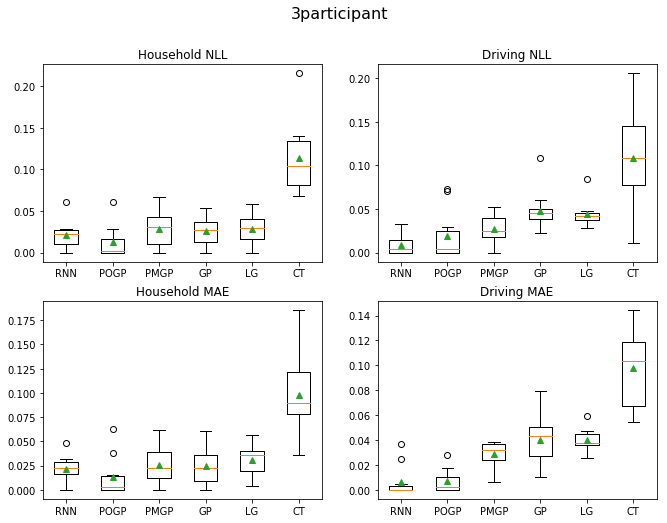

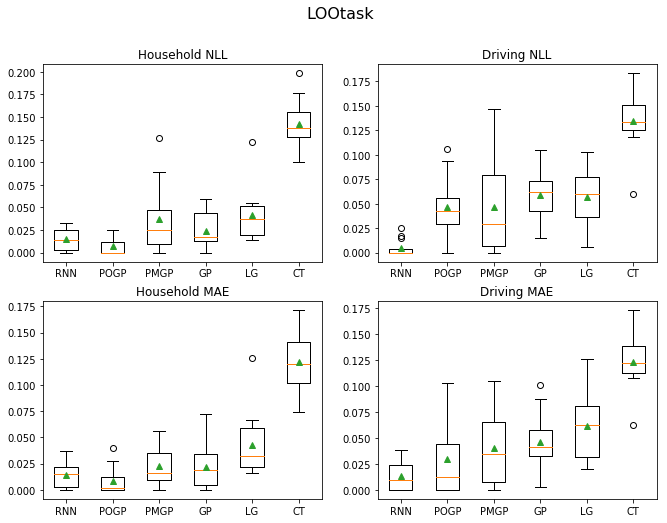

In [18]:
# allresults = []
scorenames = ["NLL", "MAE"]

for splittype in exps:
    f, axarr = plt.subplots(2, ndoms,figsize=(11, 8))
    f.suptitle(splittype, fontsize=16)
    
    for i, dom in zip(range(len(doms)), doms):
        nll, mae = getResults(dom, splittype, algs, sepparts=sepparts)
        nll, mae = getDFBScores([nll, mae])
        if scaleMAE:
            mae *= 7
        for j, score in zip(range(2), [nll, mae]):
            p1 = axarr[j,i].boxplot(score, showmeans=True)
            axarr[j,i].set_title(domnames[i] + " " + scorenames[j])
    plt.setp(axarr, xticks=range(1,len(algs)+1), xticklabels=algs);

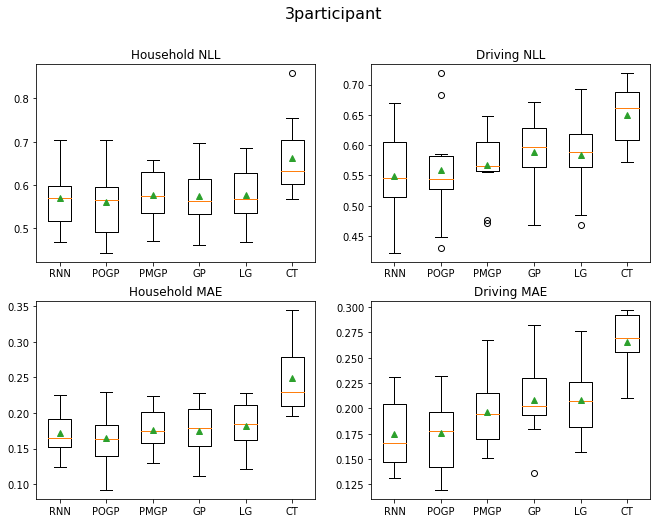

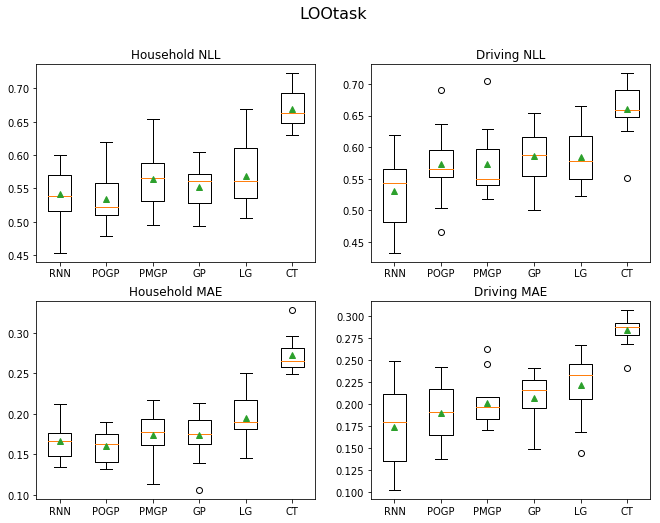

In [19]:
# allresults = []
# raw MAE and NLL plots
scorenames = ["NLL", "MAE"]

for splittype in exps:
    f, axarr = plt.subplots(2, ndoms,figsize=(11, 8))
    f.suptitle(splittype, fontsize=16)
    
    for i, dom in zip(range(len(doms)), doms):
        nll, mae = getResults(dom, splittype, algs, sepparts=sepparts)
        if scaleMAE:
            mae *= 7
        for j, score in zip(range(2), [nll, mae]):
            p1 = axarr[j,i].boxplot(score, showmeans=True)
            axarr[j,i].set_title(domnames[i] + " " + scorenames[j])
    plt.setp(axarr, xticks=range(1,len(algs)+1), xticklabels=algs);